In [154]:
from functools import partial
import numpy as np
from scipy.ndimage import uniform_filter1d
from io import StringIO
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

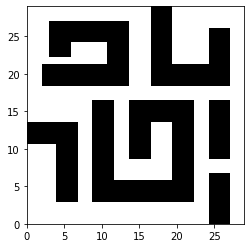

In [2]:
# Load obstacle data
filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/maps/map_difficult.png'
mapImg = cv2.imread(filename, 0)
blurImg = cv2.blur(mapImg, ksize=(3,3))

occGrid = np.clip(mapImg, 0, 1)
inflatedGrid = np.floor(blurImg / 255)
gridSize = occGrid.shape[0]

plt.imshow(inflatedGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
plt.show()

In [185]:
# define planning problem

def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


def isStateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied
    u = int(np.floor(state.getX() * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state.getY()))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def propagate(start, control, duration, state):
    state.setX(start.getX() + v * duration * np.cos(start.getYaw()))
    state.setY(start.getY() + v * duration * np.sin(start.getYaw()))
    state.setYaw(start.getYaw() + control[0] * duration)
    #state.setYaw(state.getYaw() + v / L * np.tan(control[0]) * duration)


def problemDef(ctrl=False):
    # construct the state space we are planning in
    space = ob.SE2StateSpace()

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # create a control space
    cspace = oc.RealVectorControlSpace(space, 1)

    # set the bounds for the control space
    cbounds = ob.RealVectorBounds(1)
    cbounds.setLow(-1.3)
    cbounds.setHigh(1.3)
    cspace.setBounds(cbounds)

    # define a simple setup class
    if ctrl:
        ss = oc.SimpleSetup(cspace)
        ss.setStatePropagator(oc.StatePropagatorFn(propagate))
        si = ss.getSpaceInformation()
        si.setPropagationStepSize(.05)
        planner = oc.EST(si)
    else: 
        ss = og.SimpleSetup(space)
        si = ss.getSpaceInformation()
        planner = og.RRTstar(si)

    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isStateValid, ss.getSpaceInformation())))

    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))

    return ss


def plan(planObj, initState, goalState):
    
    space = ob.SE2StateSpace()
    
    start = ob.State(space)
    start().setX(initState[0])
    start().setY(initState[1])
    start().setYaw(initState[2])

    goal = ob.State(space)
    goal().setX(goalState[0])
    goal().setY(goalState[1])
    goal().setYaw(goalState[2])
    
    planObj.setStartAndGoalStates(start, goal, 0.1)

    timeTerminationCondition = ob.timedPlannerTerminationCondition(12.0)
    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), epsilon=0.1)
    exactSolTerminationCondition = ob.exactSolnPlannerTerminationCondition(planObj.getProblemDefinition())

    orTerminationCondition = ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition)

    planObj.solve(orTerminationCondition)

In [ ]:
# generate planning data, car scenario

nData = 1 # number of plans to generate

minDistThreshold = 0.5 # minimum distance threshold betwen start/goal
v = 0.1

trajSamples = np.zeros(shape=(1, 4)) # x, y, yaw, steer
initData = np.zeros(shape=(1, 3)) # x, y, yaw
goalData = np.zeros(shape=(1, 3))
ctrlData = np.zeros(shape=(1,1)) # steering angle

pdef_state = problemDef()
pdef_ctrl = problemDef(ctrl=True)

plotPaths = True
i = 0 
nPlans = 0 # number of completed plans
while nPlans < nData:

    start = np.array([0, 0, 0]) # x, y, yaw
    goal  = np.copy(start)
    ux = 0; vx = 0; uy = 0; vy = 0
    
    while True:
        start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
        goal  = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
        ux = int(np.floor(start[0] * gridSize)) # right pointing image axis
        vx = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
        uy = int(np.floor(goal[0] * gridSize)) # right pointing image axis
        vy = int(np.floor(gridSize * (1 - goal[1]))) # down pointing image axis
        if np.linalg.norm(start[:2] - goal[:2]) > minDistThreshold and inflatedGrid[vx,ux] > 0 and inflatedGrid[vy,uy] > 0:
            break

    plan(pdef_state, start, goal)

    if pdef_state.getProblemDefinition().hasExactSolution():

        sol = np.loadtxt(StringIO(pdef_state.getSolutionPath().printAsMatrix()))
        dxdy = np.concatenate((sol[1:,0:2] - sol[:-1,0:2], (goal[:2] - sol[-1,0:2]).reshape(1, 2)), axis=0)
        xydot = dxdy / np.linalg.norm(dxdy, axis=1).reshape(sol.shape[0],1)

        if np.linalg.norm(sol[0, :2] - start[:2]) < 0.01:
            sol = sol[1:]
            xydot = xydot[1:]
        if np.linalg.norm(sol[-1, :2] - goal[:2]) < 0.01:
            sol = sol[:-1]
            xydot = xydot[:-1]

        nSamples = sol.shape[0]

        if nSamples > 0:

            start_dxdy = sol[0, :2] - start[:2]; goal_dxdy = goal[:2] - sol[-1, :2]
            start_xydot = start_dxdy / np.linalg.norm(start_dxdy); goal_xydot = goal_dxdy / np.linalg.norm(goal_dxdy)

            start[-1] = np.sign(int(start_xydot[1] > 0) - 0.5) * np.arccos(np.dot(start_xydot / np.linalg.norm(start_xydot), [1, 0])) # get yaw from xdot, ydot
            goal[-1] = np.sign(int(goal_xydot[1] > 0)- 0.5) * np.arccos(np.dot(goal_xydot / np.linalg.norm(goal_xydot), [1, 0]))

            plan(pdef_ctrl, start, goal)

            if pdef_ctrl.getProblemDefinition().hasExactSolution():

                sol = np.loadtxt(StringIO(pdef_ctrl.getSolutionPath().printAsMatrix()))[1:]
                nSamples = sol.shape[0]

                trajSamples = np.vstack((trajSamples, sol[:, 0:4])) # x, y, yaw, steer
                initData = np.vstack((initData, np.tile(start, reps=(nSamples, 1)))) # x, y, taw
                goalData = np.vstack((goalData, np.tile(goal, reps=(nSamples, 1)))) # x, y, yaw
                
                if plotPaths:
                    fig, ax = plt.subplots()
                    ax.quiver(start[0] * gridSize, start[1] * gridSize, start_xydot[0], start_xydot[1], color="red", scale=8.0, width=0.015)
                    ax.quiver(goal[0] * gridSize, goal[1] * gridSize, goal_xydot[0], goal_xydot[1], color="blue", scale=8.0, width=0.015)
                    ax.quiver(sol[:, 0] * gridSize, sol[:, 1] * gridSize, np.cos(sol[:,2]), np.sin(sol[:,2]), color="green", scale=8.0, width=0.015, alpha=0.9)
                    ax.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
                    plt.show()

                    plt.plot(np.arange(nSamples), uniform_filter1d(sol[:, 3], size=3, origin=0, mode='nearest'))
                    plt.plot(np.arange(nSamples), sol[:, 3])
                    plt.ylim([1.3, -1.3])
                    plt.show()
    
                nPlans += 1
                if nPlans % 500 == 0:
                    newData = np.concatenate((trajSamples, initData, goalData), axis=1)[1:]
                    np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/data/pathDataDifficult_n' + str(nPlans), newData, delimiter=',', fmt='%1.6f')
  
    pdef_state.clear()
    pdef_ctrl.clear()
    i += 1  

In [195]:
newData = np.concatenate((trajSamples, initData, goalData), axis=1)[1:]
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/ctrlData', newData, delimiter=',', fmt='%1.6f')